In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
train = pd.read_csv('training_set_features.csv')
test = pd.read_csv('training_set_labels.csv')

train = train.drop(columns=['rent_or_own', 'employment_occupation', 'employment_industry', 'health_insurance'])

In [5]:
[i for i in train.columns if train[i].dtype == 'object']

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'employment_status',
 'hhs_geo_region',
 'census_msa']

In [6]:
train.dtypes

respondent_id                    int64
xyz_concern                    float64
xyz_knowledge                  float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_xyz                float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
opinion_xyz_vacc_effective     float64
opinion_xyz_risk               float64
opinion_xyz_sick_from_vacc     float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

In [11]:
cleanup = { 
                "age_group": {"18 - 34 Years": 0, "35 - 44 Years": 1, "45 - 54 Years" : 2, "55 - 64 Years" : 3, "65+ Years" : 4},
                "income_poverty" : {'Below Poverty' : 0, '<= $75,000, Above Poverty' : 1, '> $75,000' : 2},
                "education" : {'< 12 Years' : 0, '12 Years' : 1, 'College Graduate' : 2, 'Some College' : 3}
}
train = train.replace(cleanup)

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.impute import KNNImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
cat_cols = ['opinion_xyz_vacc_effective', 'opinion_xyz_risk',
            'opinion_xyz_sick_from_vacc', 'opinion_seas_vacc_effective',
            'opinion_seas_risk', 'opinion_seas_sick_from_vacc']

imp = SimpleImputer(strategy='most_frequent')
for name, group in train.groupby(['census_msa', 'hhs_geo_region']):
    mask = (train['census_msa'] == name[0]) & (train['hhs_geo_region'] == name[1])
    train.loc[mask, cat_cols] = imp.fit_transform(group[cat_cols])

cat_cols = ['behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home']

for name, group in train.groupby(['age_group', 'race', 'sex', 'census_msa', 'hhs_geo_region']):
    mask =  (train['age_group'] == name[0]) & (train['race'] == name[1]) &(train['sex'] == name[2])& (train['census_msa'] == name[3]) & (train['hhs_geo_region'] == name[4])
    
    train.loc[mask, cat_cols] = imp.fit_transform(group[cat_cols])

cat_cols = ['chronic_med_condition', 'education']
for name, group in train.groupby(['age_group', 'sex', 'census_msa', 'hhs_geo_region']):
    mask =  (train['age_group'] == name[0]) & (train['sex'] == name[1])& (train['census_msa'] == name[2]) & (train['hhs_geo_region'] == name[3])
    train.loc[mask, cat_cols] = imp.fit_transform(group[cat_cols])

In [14]:
imp1 = SimpleImputer(strategy='median')

num_cols = ['household_adults', 'household_children']
for name, group in train.groupby(['race', 'census_msa', 'hhs_geo_region']):
    mask = (train['race'] == name[0]) & (train['census_msa'] == name[1]) & (train['hhs_geo_region'] == name[2])
    train.loc[mask, num_cols] = imp1.fit_transform(group[num_cols])

In [17]:
import math
cat_cols = ['xyz_concern', 'xyz_knowledge']

for name, group in train.groupby(['census_msa', 'hhs_geo_region']):
    mask = (train['census_msa'] == name[0]) & (train['hhs_geo_region'] == name[1])
    train.loc[mask, cat_cols] = imp.fit_transform(group[cat_cols])

cat_cols = ['marital_status', 'employment_status', 'income_poverty']

for name, group in train.groupby(['sex', 'race', 'age_group']):
    mask = (train['sex'] == name[0]) & (train['race'] == name[1]) & (train['age_group'] == name[2])
    train.loc[mask, cat_cols] = imp.fit_transform(group[cat_cols])

cat_cols = ['doctor_recc_seasonal', 'doctor_recc_xyz']

for name, group in train.groupby(['age_group', 'chronic_med_condition']):
    mask = (train['age_group'] == name[0]) & (train['chronic_med_condition'] == name[1])
    train.loc[mask, cat_cols] = imp.fit_transform(group[cat_cols])


def f1(cols):
    b = cols.iloc[0]
    b1 = cols.iloc[1]
    b2 = cols.iloc[2]
    b3 = cols.iloc[3]
    b4 = cols.iloc[4]

    if math.isnan(b) :
        sum = (b1 == 0) + (b2 == 0) + (b3 == 0) + (b4 == 0)
        if sum > 2 :
            return 0
        else :
            return 1
    else :
        return b

train['behavioral_face_mask'] = train[['behavioral_face_mask', 'behavioral_avoidance', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home']].apply(f1, axis=1)
train['behavioral_touch_face'] = train[['behavioral_touch_face', 'behavioral_avoidance', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home']].apply(f1, axis=1)

filter_ = train.isna().sum(axis=1) == 0
train = train[filter_]
test = test[filter_]

<Axes: >

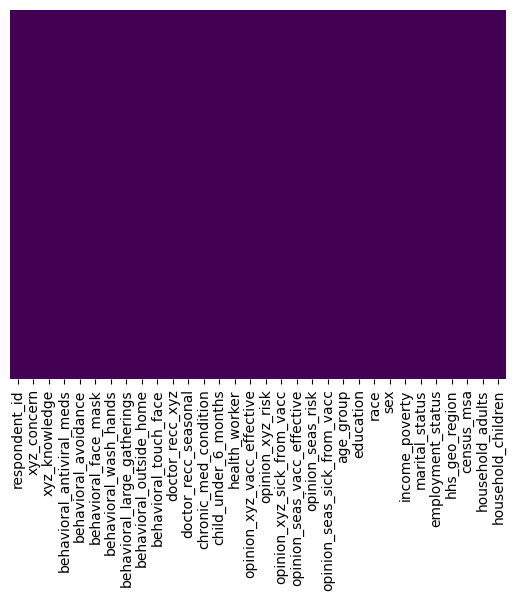

In [19]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [21]:
sum(train.isna().sum(axis=1) > 0)

0

In [23]:
train["census_msa"] = train["census_msa"].astype('category')
train["hhs_geo_region"] = train["hhs_geo_region"].astype('category')

train["census_msa"] = train["census_msa"].cat.codes
train["hhs_geo_region"] = train["hhs_geo_region"].cat.codes

In [25]:
train2 = train.copy()
print(train2.shape)
train.dtypes

(25871, 32)


respondent_id                    int64
xyz_concern                    float64
xyz_knowledge                  float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_xyz                float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
opinion_xyz_vacc_effective     float64
opinion_xyz_risk               float64
opinion_xyz_sick_from_vacc     float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                        int64
education                      float64
race                            object
sex                             object
income_poverty           

In [27]:
train = pd.get_dummies(train, columns=["marital_status"])
train = pd.get_dummies(train, columns=["employment_status"])
train = pd.get_dummies(train, columns=["sex"])
train = pd.get_dummies(train, columns=["race"])

In [14]:
train

,respondent_id,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,marital_status_Not Married,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,sex_Female,sex_Male,race_Black,race_Hispanic,race_Other or Multiple,race_White
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,True,False,True,False,True,False,False,False,False,True
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,True,True,False,False,False,True,False,False,False,True
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,True,True,False,False,False,True,False,False,False,True
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,True,False,True,False,True,False,False,False,False,True
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,False,True,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,True,False,True,False,True,False,False,False,False,True
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,True,True,False,False,False,True,False,False,False,True
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,True,True,False,False,True,False,False,False,False,True
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,False,True,False,False,True,False,False,True,False,False


In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [31]:
test.columns

Index(['respondent_id', 'xyz_vaccine', 'seasonal_vaccine'], dtype='object')

In [33]:
X = train.copy()   # replace by train after removing null values
X = X.drop(columns=['doctor_recc_seasonal', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc'])
y = test['xyz_vaccine'].copy()    # replace with the labels (test)

In [35]:
X.dtypes

respondent_id                             int64
xyz_concern                             float64
xyz_knowledge                           float64
behavioral_antiviral_meds               float64
behavioral_avoidance                    float64
behavioral_face_mask                    float64
behavioral_wash_hands                   float64
behavioral_large_gatherings             float64
behavioral_outside_home                 float64
behavioral_touch_face                   float64
doctor_recc_xyz                         float64
chronic_med_condition                   float64
child_under_6_months                    float64
health_worker                           float64
opinion_xyz_vacc_effective              float64
opinion_xyz_risk                        float64
opinion_xyz_sick_from_vacc              float64
age_group                                 int64
education                               float64
income_poverty                          float64
hhs_geo_region                          

In [37]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a parameter grid for alpha
param_grid = {'alpha': np.logspace(-4, 1, 50)}

# Initialize Lasso
lasso = Lasso(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to find the best alpha
grid_search.fit(X_train_scaled, y_train)

# Best alpha found
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha found: {best_alpha}")

# Fit Lasso with the best alpha on the full dataset
lasso_best = Lasso(alpha=best_alpha, random_state=42)
lasso_best.fit(X_train_scaled, y_train)

# Predict and evaluate Lasso with best alpha
y_pred_best = lasso_best.predict(X_test_scaled)
print(f"Lasso Regression with best alpha MSE: {mean_squared_error(y_test, y_pred_best)}")

# Initialize RFE with Lasso using the best alpha
rfe = RFE(estimator=lasso_best, n_features_to_select=15, step=1)
rfe.fit(X_train_scaled, y_train)

# Transform the data
X_train_rfe = rfe.transform(X_train_scaled)
X_test_rfe = rfe.transform(X_test_scaled)

# Fit Lasso with the best alpha on the reduced features
lasso_rfe_best = Lasso(alpha=best_alpha, random_state=42)
lasso_rfe_best.fit(X_train_rfe, y_train)

# Predict and evaluate Lasso with RFE and best alpha
y_pred_rfe_best = lasso_rfe_best.predict(X_test_rfe)
print(f"Lasso with RFE and best alpha MSE: {mean_squared_error(y_test, y_pred_rfe_best)}")

# Get selected feature names
selected_features_xyz = X.columns[rfe.support_]
print(f"Selected features: {selected_features_xyz}")


Best alpha found: 0.0010481131341546852
Lasso Regression with best alpha MSE: 0.1177025514922193
Lasso with RFE and best alpha MSE: 0.11785880062238321
Selected features: Index(['xyz_concern', 'xyz_knowledge', 'behavioral_large_gatherings',
       'doctor_recc_xyz', 'child_under_6_months', 'health_worker',
       'opinion_xyz_vacc_effective', 'opinion_xyz_risk',
       'opinion_xyz_sick_from_vacc', 'age_group', 'income_poverty',
       'marital_status_Married', 'employment_status_Not in Labor Force',
       'sex_Female', 'race_Black'],
      dtype='object')


In [39]:
X1 = train.copy()   # replace by train after removing null values
X1 = X1.drop(columns=['xyz_knowledge','xyz_concern','doctor_recc_xyz', 'opinion_xyz_vacc_effective', 'opinion_xyz_risk', 'opinion_xyz_sick_from_vacc'])

y = test['seasonal_vaccine'].copy()    # replace with the labels (test)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a parameter grid for alpha
param_grid = {'alpha': np.logspace(-4, 1, 50)}

# Initialize Lasso
lasso = Lasso(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to find the best alpha
grid_search.fit(X_train_scaled, y_train)

# Best alpha found
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha found: {best_alpha}")

# Fit Lasso with the best alpha on the full dataset
lasso_best = Lasso(alpha=best_alpha, random_state=42)
lasso_best.fit(X_train_scaled, y_train)

# Predict and evaluate Lasso with best alpha
y_pred_best = lasso_best.predict(X_test_scaled)
print(f"Lasso Regression with best alpha MSE: {mean_squared_error(y_test, y_pred_best)}")

# Initialize RFE with Lasso using the best alpha
rfe = RFE(estimator=lasso_best, n_features_to_select=15, step=1)
rfe.fit(X_train_scaled, y_train)

# Transform the data
X_train_rfe = rfe.transform(X_train_scaled)
X_test_rfe = rfe.transform(X_test_scaled)

# Fit Lasso with the best alpha on the reduced features
lasso_rfe_best = Lasso(alpha=best_alpha, random_state=42)
lasso_rfe_best.fit(X_train_rfe, y_train)

# Predict and evaluate Lasso with RFE and best alpha
y_pred_rfe_best = lasso_rfe_best.predict(X_test_rfe)
print(f"Lasso with RFE and best alpha MSE: {mean_squared_error(y_test, y_pred_rfe_best)}")

# Get selected feature names
selected_features_seas = X1.columns[rfe.support_]
print(f"Selected features: {selected_features_seas}")

Best alpha found: 0.0016768329368110084
Lasso Regression with best alpha MSE: 0.1635122318559634
Lasso with RFE and best alpha MSE: 0.16340620126698893
Selected features: Index(['behavioral_touch_face', 'doctor_recc_seasonal',
       'chronic_med_condition', 'health_worker', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'income_poverty', 'census_msa',
       'employment_status_Not in Labor Force', 'employment_status_Unemployed',
       'race_Black', 'race_Hispanic'],
      dtype='object')


In [99]:
X = X.loc[:, selected_features_xyz]
X1 = X1.loc[:, selected_features_seas]
X_test = pd.read_csv('test_set_features.csv')

cleanup = { 
                "age_group": {"18 - 34 Years": 0, "35 - 44 Years": 1, "45 - 54 Years" : 2, "55 - 64 Years" : 3, "65+ Years" : 4},
                "income_poverty" : {'Below Poverty' : 0, '<= $75,000, Above Poverty' : 1, '> $75,000' : 2},
                "education" : {'< 12 Years' : 0, '12 Years' : 1, 'College Graduate' : 2, 'Some College' : 3}
}
X_test = X_test.replace(cleanup)
X_test = X_test.drop(columns=['rent_or_own', 'employment_occupation', 'employment_industry', 'health_insurance'])

In [100]:
X_test.columns

Index(['respondent_id', 'xyz_concern', 'xyz_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_xyz', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'opinion_xyz_vacc_effective', 'opinion_xyz_risk',
       'opinion_xyz_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'employment_status', 'hhs_geo_region', 'census_msa', 'household_adults',
       'household_children'],
      dtype='object')

In [103]:
X_test["census_msa"] = X_test["census_msa"].astype('category')
X_test["hhs_geo_region"] = X_test["hhs_geo_region"].astype('category')

X_test["census_msa"] = X_test["census_msa"].cat.codes
X_test["hhs_geo_region"] = X_test["hhs_geo_region"].cat.codes

In [105]:
# Define columns to impute and their grouping columns
impute_cols = {
    'behavioral_antiviral_meds': ['age_group', 'race', 'sex', 'hhs_geo_region', 'census_msa'],
    'behavioral_avoidance': ['age_group', 'race', 'sex', 'hhs_geo_region', 'census_msa'],
    'behavioral_face_mask': ['age_group', 'race', 'sex', 'hhs_geo_region', 'census_msa'],
    'behavioral_wash_hands': ['age_group', 'race', 'sex', 'hhs_geo_region', 'census_msa'],
    'behavioral_large_gatherings': ['age_group', 'race', 'sex', 'hhs_geo_region', 'census_msa'],
    'behavioral_outside_home': ['age_group', 'race', 'sex', 'hhs_geo_region', 'census_msa'],
    'behavioral_touch_face': ['age_group', 'race', 'sex', 'hhs_geo_region', 'census_msa'],
    'doctor_recc_xyz': ['age_group', 'chronic_med_condition'],
    'doctor_recc_seasonal': ['age_group', 'chronic_med_condition'],
    'chronic_med_condition': ['age_group', 'sex', 'census_msa', 'hhs_geo_region'],
    'child_under_6_months': ['age_group', 'sex', 'census_msa', 'hhs_geo_region'],
    'health_worker': ['age_group', 'sex', 'census_msa', 'hhs_geo_region'],
    'opinion_xyz_vacc_effective': ['census_msa', 'hhs_geo_region'],
    'opinion_xyz_risk': ['census_msa', 'hhs_geo_region'],
    'opinion_xyz_sick_from_vacc': ['census_msa', 'hhs_geo_region'],
    'opinion_seas_vacc_effective': ['census_msa', 'hhs_geo_region'],
    'opinion_seas_risk': ['census_msa', 'hhs_geo_region'],
    'opinion_seas_sick_from_vacc': ['census_msa', 'hhs_geo_region'],
    'education': ['age_group', 'sex', 'census_msa', 'hhs_geo_region'],
    'income_poverty': ['sex', 'race', 'age_group'],
    'marital_status': ['sex', 'race', 'age_group'],
    'employment_status': ['sex', 'race', 'age_group'],
    'xyz_knowledge': ['census_msa', 'hhs_geo_region'],
    'xyz_concern': ['census_msa', 'hhs_geo_region'],
}

# Function to fill missing values based on mode from training data
def fill_missing_with_mode(train_df, test_df, column, group_cols):
    # Compute mode values for each group
    mode_values = train_df.groupby(group_cols)[column].agg(lambda x: pd.Series.mode(x)[0])
    
    # Function to fetch mode value for a row
    def fetch_mode(row):
        group = tuple(row[col] for col in group_cols)
        return mode_values.get(group, row[column]) if pd.isnull(row[column]) else row[column]
    
    # Apply the function to fill missing values
    test_df[column] = test_df.apply(fetch_mode, axis=1)
    return test_df

# Apply the function for each column
for col, group_cols in impute_cols.items():
    X_test = fill_missing_with_mode(train2, X_test, col, group_cols)

print(X_test)

       respondent_id  xyz_concern  xyz_knowledge  behavioral_antiviral_meds  \
0              26707          2.0            2.0                        0.0   
1              26708          1.0            1.0                        0.0   
2              26709          2.0            2.0                        0.0   
3              26710          1.0            1.0                        0.0   
4              26711          3.0            1.0                        1.0   
...              ...          ...            ...                        ...   
26703          53410          1.0            1.0                        0.0   
26704          53411          3.0            1.0                        0.0   
26705          53412          0.0            1.0                        0.0   
26706          53413          3.0            1.0                        0.0   
26707          53414          2.0            1.0                        0.0   

       behavioral_avoidance  behavioral_face_mask  

In [106]:
median_impute_cols = {
    'household_adults': ['race', 'census_msa', 'hhs_geo_region'],
    'household_children': ['race', 'census_msa', 'hhs_geo_region']
}

# Function to fill missing values based on median from training data
def fill_missing_with_median(train_df, test_df, column, group_cols):
    # Compute median values for each group
    median_values = train_df.groupby(group_cols)[column].median()
    
    # Function to fetch median value for a row
    def fetch_median(row):
        group = tuple(row[col] for col in group_cols)
        return median_values.get(group, row[column]) if pd.isnull(row[column]) else row[column]
    
    # Apply the function to fill missing values
    test_df[column] = test_df.apply(fetch_median, axis=1)
    return test_df

# Apply the function for each column
for col, group_cols in median_impute_cols.items():
    X_test = fill_missing_with_median(train2, X_test, col, group_cols)

In [107]:
behavioral_cols = [
    'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask',
    'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home',
    'behavioral_touch_face'
]

# Custom function to impute missing values based on the mode of other behavioral attributes
def impute_behavioral_custom_mode(row, behavioral_cols, column_to_impute):
    # Exclude the column to impute from the list of behavioral columns
    other_cols = [col for col in behavioral_cols if col != column_to_impute]
    other_values = row[other_cols].dropna()
    if len(other_values) > 0:
        # Calculate the mode of the other behavioral columns
        mode_value = other_values.mode()
        if not mode_value.empty:
            return mode_value.iloc[0]
        else:
            return np.nan  # Or some default value
    else:
        return np.nan  # Or some default value

# Wrapper function to apply the custom imputation
def apply_custom_imputation_mode(df, column, behavioral_cols):
    df[column] = df.apply(
        lambda row: impute_behavioral_custom_mode(row, behavioral_cols, column) if pd.isnull(row[column]) else row[column],
        axis=1
    )
    return df

# Apply imputation to target columns
X_test = apply_custom_imputation_mode(X_test, 'behavioral_avoidance', behavioral_cols)
X_test = apply_custom_imputation_mode(X_test, 'behavioral_touch_face', behavioral_cols)

In [108]:
impute_cols = {
    'doctor_recc_xyz': ['age_group', 'chronic_med_condition'],
    'doctor_recc_seasonal': ['age_group', 'chronic_med_condition'],
}

# Function to fill missing values based on mode from training data
def fill_missing_with_mode(train_df, test_df, column, group_cols):
    # Compute mode values for each group
    mode_values = train_df.groupby(group_cols)[column].agg(lambda x: pd.Series.mode(x)[0])
    
    # Function to fetch mode value for a row
    def fetch_mode(row):
        group = tuple(row[col] for col in group_cols)
        return mode_values.get(group, row[column]) if pd.isnull(row[column]) else row[column]
    
    # Apply the function to fill missing values
    test_df[column] = test_df.apply(fetch_mode, axis=1)
    return test_df

# Apply the function for each column
for col, group_cols in impute_cols.items():
    X_test = fill_missing_with_mode(train2, X_test, col, group_cols)

In [109]:
X_test = pd.get_dummies(X_test, columns=["marital_status"])
X_test = pd.get_dummies(X_test, columns=["employment_status"])
X_test = pd.get_dummies(X_test, columns=["sex"])
X_test = pd.get_dummies(X_test, columns=["race"])

In [110]:
X_test.isna().sum(axis=0) > 0

respondent_id                           False
xyz_concern                             False
xyz_knowledge                           False
behavioral_antiviral_meds               False
behavioral_avoidance                    False
behavioral_face_mask                    False
behavioral_wash_hands                   False
behavioral_large_gatherings             False
behavioral_outside_home                 False
behavioral_touch_face                   False
doctor_recc_xyz                         False
doctor_recc_seasonal                    False
chronic_med_condition                   False
child_under_6_months                    False
health_worker                           False
opinion_xyz_vacc_effective              False
opinion_xyz_risk                        False
opinion_xyz_sick_from_vacc              False
opinion_seas_vacc_effective             False
opinion_seas_risk                       False
opinion_seas_sick_from_vacc             False
age_group                         

In [136]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, log_loss

# # Load and prepare the dataset
# y = test['xyz_vaccine'].copy()
# # Split the data
# X_train = X
# y_train = y

# X_test1 = X_test.loc[:, selected_features_xyz]
# # Standardize the data (for SVM)
# # scaler = StandardScaler()
# # X_train_scaled = scaler.fit_transform(X_train)
# # X_test_scaled = scaler.transform(X_test)

# # Initialize models
# # Multinomial Naive Bayes expects positive feature values
# # To make the data compatible, we'll use MinMax scaling here instead of standard scaling
# from sklearn.preprocessing import MinMaxScaler
# scaler_minmax = MinMaxScaler()
# X_train_mm = scaler_minmax.fit_transform(X_train)
# X_test_mm = scaler_minmax.transform(X_test1)

# nb = MultinomialNB()
# # svc = SVC(probability=True, random_state=42)  # SVM with probability estimates

# # Fit models
# nb.fit(X_train_mm, y_train)
# # svc.fit(X_train_scaled, y_train)

# X_test_to_use = X_test_mm
# y_proba1 = nb.predict_proba(X_test_to_use)

In [132]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, log_loss

# # Load and prepare the dataset
# y = test['seasonal_vaccine'].copy()
# # Split the data
# X_train = X1
# y_train = y

# # Standardize the data (for SVM)
# # scaler = StandardScaler()
# # X_train_scaled = scaler.fit_transform(X_train)
# # X_test_scaled = scaler.transform(X_test)
# X_test2 = X_test2.loc[:, selected_features_seas]
# # Initialize models
# # Multinomial Naive Bayes expects positive feature values
# # To make the data compatible, we'll use MinMax scaling here instead of standard scaling
# from sklearn.preprocessing import MinMaxScaler
# scaler_minmax = MinMaxScaler()
# X_train_mm = scaler_minmax.fit_transform(X_train)
# X_test_mm = scaler_minmax.transform(X_test2)

# nb = MultinomialNB()
# # svc = SVC(probability=True, random_state=42)  # SVM with probability estimates

# # Fit models
# nb.fit(X_train_mm, y_train)
# # svc.fit(X_train_scaled, y_train)

# X_test_to_use = X_test_mm
# y_proba2 = nb.predict_proba(X_test_to_use)

In [185]:
# ids = X_test['respondent_id']

# # Create a DataFrame with `id` and predicted values
# results_df = pd.DataFrame({
#     'id': ids,
#     'xyz_vaccine': y_proba1[:, 0],
#     'seasonal_vaccine': y_proba2[:,0]
# })

# # Write to CSV
# results_df.to_csv('predictions.csv', index=False)

# print(results_df)

In [126]:
# from sklearn.metrics import accuracy_score, roc_auc_score

# y = test['seasonal_vaccine'].copy()
# # Split the data into train and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X1, y, test_size=0.2, random_state=42)

# # Apply Min-Max scaling to the data (suitable for MultinomialNB)
# scaler_minmax = MinMaxScaler()
# X_train_mm = scaler_minmax.fit_transform(X_train)
# X_val_mm = scaler_minmax.transform(X_val)

# # Initialize and train the Multinomial Naive Bayes model
# nb = MultinomialNB()
# nb.fit(X_train_mm, y_train)

# # Predict probabilities on the validation set
# y_val_proba = nb.predict_proba(X_val_mm)[:, 1]  # Get the probability of the positive class

# # Evaluate the model
# # Compute accuracy
# accuracy = accuracy_score(y_val, nb.predict(X_val_mm))
# print(f"Accuracy: {accuracy}")

# # Compute AUC-ROC
# auc_roc = roc_auc_score(y_val, y_val_proba)
# print(f"AUC-ROC: {auc_roc}")

Accuracy: 0.7169082125603865
AUC-ROC: 0.7678725662525764


In [134]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Assuming X1 contains your features and y contains your target variable
y = test['xyz_vaccine'].copy()

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# To use early stopping, specify a watchlist and a number of rounds
watchlist = [(dtrain, 'train'), (dval, 'eval')]

num_rounds = 1000
xgb_model = xgb.train(params, dtrain, num_rounds, evals=watchlist, early_stopping_rounds=20, verbose_eval=True)

# Predict probabilities on the validation set
y_val_proba = xgb_model.predict(dval, iteration_range=(0, xgb_model.best_iteration))

# Convert probabilities to binary predictions
y_val_pred = (y_val_proba >= 0.5).astype(int)

# Evaluate the model
# Compute accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy}")

# Compute AUC-ROC
auc_roc = roc_auc_score(y_val, y_val_proba)
print(f"AUC-ROC: {auc_roc}")

[0]	train-auc:0.80577	eval-auc:0.81372
[1]	train-auc:0.82871	eval-auc:0.83542
[2]	train-auc:0.82851	eval-auc:0.83549
[3]	train-auc:0.83287	eval-auc:0.83996
[4]	train-auc:0.83408	eval-auc:0.84150
[5]	train-auc:0.83350	eval-auc:0.84005
[6]	train-auc:0.83601	eval-auc:0.84123
[7]	train-auc:0.83699	eval-auc:0.84244
[8]	train-auc:0.83875	eval-auc:0.84312
[9]	train-auc:0.83993	eval-auc:0.84341
[10]	train-auc:0.84007	eval-auc:0.84339
[11]	train-auc:0.84052	eval-auc:0.84337
[12]	train-auc:0.84095	eval-auc:0.84340
[13]	train-auc:0.84153	eval-auc:0.84370
[14]	train-auc:0.84216	eval-auc:0.84386
[15]	train-auc:0.84268	eval-auc:0.84387
[16]	train-auc:0.84305	eval-auc:0.84409
[17]	train-auc:0.84352	eval-auc:0.84406
[18]	train-auc:0.84416	eval-auc:0.84402
[19]	train-auc:0.84443	eval-auc:0.84425
[20]	train-auc:0.84469	eval-auc:0.84412
[21]	train-auc:0.84497	eval-auc:0.84426
[22]	train-auc:0.84555	eval-auc:0.84480
[23]	train-auc:0.84601	eval-auc:0.84476
[24]	train-auc:0.84670	eval-auc:0.84506
[25]	train

In [164]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

y = test['xyz_vaccine'].copy()
X_test1 = X_test.loc[:, selected_features_xyz]

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

dtrain_full = xgb.DMatrix(X, label=y) 

num_rounds = 1000
xgb_model = xgb.train(params, dtrain_full, num_rounds)

dtest = xgb.DMatrix(X_test1)

y_test_proba = xgb_model.predict(dtest)

y_test_proba_np = np.round(y_test_proba, 4)

In [163]:
y = test['seasonal_vaccine'].copy()
X_test2 = X_test.loc[:, selected_features_seas]

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

dtrain_full = xgb.DMatrix(X1, label=y) 

num_rounds = 1000
xgb_model = xgb.train(params, dtrain_full, num_rounds)

dtest = xgb.DMatrix(X_test2)

y_test_proba2 = xgb_model.predict(dtest)

y_test_proba_np2 = np.round(y_test_proba2, 4)

In [182]:
ids = X_test['respondent_id']

# Create a DataFrame with `id` and predicted values
results_df = pd.DataFrame({
    'id': ids,
    'h1n1_vaccine': y_test_proba_np,
    'seasonal_vaccine': y_test_proba_np2
})

# Write to CSV
results_df.to_csv('predictions.csv', index=False)

print(results_df)

          id  h1n1_vaccine  seasonal_vaccine
0      26707        0.0120            0.1688
1      26708        0.0165            0.0042
2      26709        0.3154            0.8595
3      26710        0.5055            0.8650
4      26711        0.2426            0.8185
...      ...           ...               ...
26703  53410        0.2094            0.4387
26704  53411        0.5595            0.2978
26705  53412        0.0298            0.0339
26706  53413        0.0003            0.2986
26707  53414        0.1550            0.6769

[26708 rows x 3 columns]
